## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

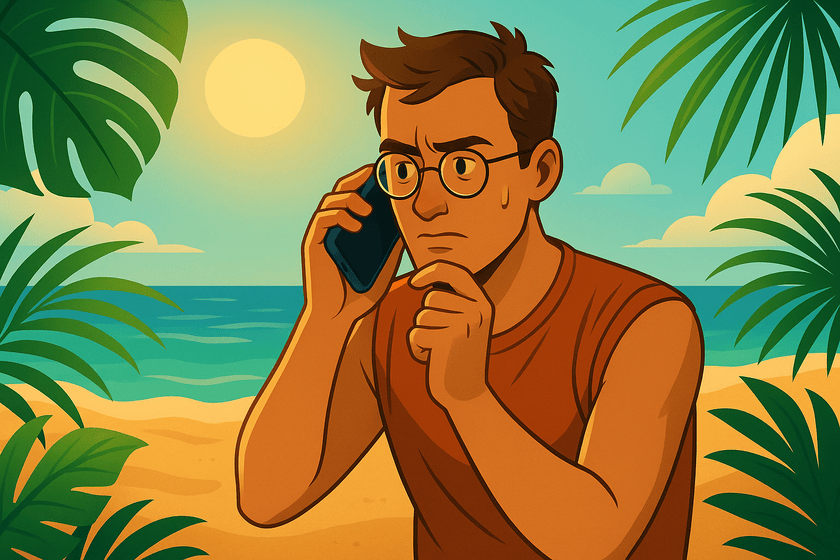

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Znowu trochę dużo importów xd

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import time
import random
from torch.optim import Adam
from torch.utils.data import TensorDataset
import pandas as pd
from matplotlib import cm
from matplotlib.colors import Normalize
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="urllib3")

/Users/jakubsmolarczyk/Desktop/katalogi/pythons/CPSiO/pythonProject/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


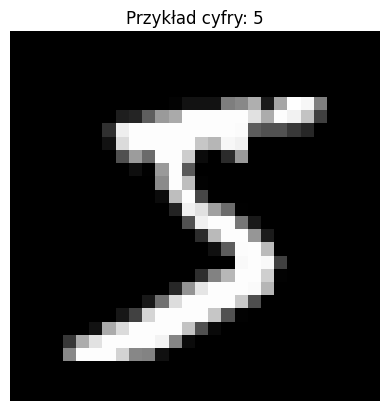

In [3]:
# ładowanie zbioru danych
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

plt.imshow(x_train[0], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[0]}")
plt.axis('off')
plt.show()

Jako że wytrenowanie modelu na całym zestawie danych zajęłoby sporo czasu to wydzieliłem mniejszy podzbiór. Poniżej tworzę go z co 4-ego elementu z pierwotnego zbioru.

In [65]:
baseline_x_train = x_train[::4]
baseline_y_train = y_train[::4]

baseline_x_test = x_test[::4]
baseline_y_test = y_test[::4]

Tworzenie datasetów pod DataLoadery poniżej. Przy okazji, ze zbioru treningowego wydzieliłem 10% danych do zbioru walidacyjnego.

In [66]:
val_size = int(len(baseline_x_train) / 10)
train_size = len(baseline_x_train) - val_size

baseline_dataset = TensorDataset(torch.Tensor(baseline_x_train), torch.Tensor(baseline_y_train).long())
train_ds, val_ds = random_split(baseline_dataset, [train_size, val_size])
test_ds = TensorDataset(torch.Tensor(baseline_x_test), torch.Tensor(baseline_y_test).long())

In [67]:
BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

Omyłkowo wyczerpałem swój dostęp do GPU google collab'a, więc musiałem się posiłkować własnym ... <br>
*bro has no CUDA* 🥀

In [61]:
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
device

device(type='mps')

Baseline w postaci zwykłej sieci. W `__init__` można ustawić dowolną liczbę warstw oraz ich rozmiary, co będzie niżej badane ...

In [9]:
class BaselineNN(nn.Module):
    def __init__(self, num_classes=10, layers_num=1, layer_width=100):
        super().__init__()
        self.layers_num = layers_num
        self.input_layer = nn.Linear(28 * 28, layer_width)
        self.hidden_layer = nn.Linear(layer_width, layer_width)
        self.output_layer = nn.Linear(layer_width, num_classes)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.input_layer(x))
        for num in range(self.layers_num-1):
            x = F.relu(self.hidden_layer(x))
        x = self.output_layer(x)
        return x

NNmodel = BaselineNN().to(device)

... oraz model CNN. Dla tego modelu będę badał liczbę kanałów oraz wskaźnik dropout'u. Osobne badanie przeprowadzę również dla modelu z włączonym `batch_norm`.

In [10]:
class CNN(nn.Module):
    def __init__(self, num_classes=10, channels_num=32, dropout_rate=0.25, batch_norm=False):
        super().__init__()
        self.batch_norm = batch_norm
        self.conv1 = nn.Conv2d(1, channels_num, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels_num)
        self.conv2 = nn.Conv2d(channels_num, channels_num * 2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels_num * 2)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1  = nn.Linear(channels_num * 2 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        if self.batch_norm:
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
        else:
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Funkcja pojedynczej epoki ... podbrana ze ściągi :]

In [11]:
def run_epoch(optimizer, criterion, model, loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

Trenowanie modelu też podbrane, ale wydzielone do nowej funkcji. Dodałem do tego jeszcze możliwość ustawienia liczby epok oraz zwracanie historii uczenia modelu na żądanie.

In [69]:
def train_model(model, epochs=5, track_history=False):
    EPOCHS = epochs
    lr = 1e-3
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    start = time.time()
    for epoch in range(1, EPOCHS+1):
        tr_loss, tr_acc = run_epoch(optimizer, criterion, model, train_loader, train=True)
        va_loss, va_acc = run_epoch(optimizer, criterion, model, val_loader, train=False)
        if track_history:
            history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
            history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
            # można to odkomentować, ale imo zaśmiecało notatnik xd
            # print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
    print(f"Czas treningu: {time.time()-start:.1f}s")
    if track_history:
        return history

No i ewaluacja modelu też jako osobna funkcja. Tutaj zwracane są wartości y przewidywane i rzeczywiste do dalszego przetworzenia ...

In [13]:
def evaluate_model(model):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device, non_blocking=True)
            logits = model(xb)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(yb.numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_targets)
    return y_pred, y_true

... w poniższej funkcji, która sprawdza wszystkie możliwe kombinacje podanych parametrów.

In [48]:
def Neural_grid_search(param1, param2, isCNN=False, batch_norm=False):
    # utworzenie wyjściowej ramki
    output_frame = pd.DataFrame()

    # nazwy i wartości badanych parametrów
    param1_key = list(param1.keys())[0]
    param2_key = list(param2.keys())[0]
    param1_vals = list(param1.values())[0]
    param2_vals = list(param2.values())[0]

    # zmienne do zapisania najlepszej kombinacji
    best_accuracy = 0.0
    best_model = None

    # pętla do badania wszystkich kombinacji
    for par1 in param1_vals:
        for par2 in param2_vals:
            Neural_model = None
            if isCNN:
                Neural_model = CNN(channels_num=par1, dropout_rate=par2, batch_norm=batch_norm).to(device)
            else:
                Neural_model = BaselineNN(layers_num=par1, layer_width=par2).to(device)
            train_model(Neural_model) # trenowanie
            y_pred, y_true = evaluate_model(Neural_model) # ewaluacja
            report = classification_report(y_true, y_pred, output_dict=True) # raporcik

            # wydobycie wybranych informacji z powyższego raportu (accuracy oraz średnia ważona precision, recall i f1)
            frame_row = pd.DataFrame.from_dict(list(report.values())[-1], orient='index').T
            acc = list(report.values())[-3]

            # aktualizacja best_modelu jeśli najlepszy z dotychczasowych modeli
            if acc > best_accuracy:
                best_accuracy = acc
                best_model = Neural_model

            frame_row['accuracy'] = acc
            frame_row[param1_key] = par1
            frame_row[param2_key] = par2
            # złączenie wyników aktualnego modelu z pozostałymi
            output_frame = pd.concat([output_frame, frame_row])

    # ustawienie poprawnego indeksu
    output_frame.reset_index(inplace=True)
    output_frame.drop(columns=['index', 'support'], inplace=True)
    return output_frame, best_model

Okej, wszystkie potrzebne do treningu klasy i funkcje przedstawione zostały wyżej, to teraz czas na trening. W zwykłej sieci badam liczbę warstw oraz ich wielkość dla podanych niżej kombinacji. Pod sekcją kodu zobaczyć można przykładowe wiersze z zachowanej ramki. Ponadto w `best_NN_model` zapisałem model z największą dokładnością. Jako że wartości wszystkich uwzględnionych metryk nie różnią się zbytnio pomiędzy sobą, to pozwoliłem sobie pominąć wszystkie poza podstawą metryką czyli `accuracy` podczas analizy wyników tych badań.

In [21]:
hidden_layers = {'hidden_layers' : [1, 2, 3, 4, 5, 6, 7]}
layer_width = {'layer_width' : [25, 50, 75, 100, 125, 150, 175, 200]}
NNresults, best_NN_model = Neural_grid_search(hidden_layers, layer_width)
NNresults.head(4)

,precision,recall,f1-score,accuracy,hidden_layers,layer_width
0,0.856450,0.8524,0.852138,0.8524,1,25
1,0.905503,0.9024,0.902783,0.9024,1,50
2,0.915701,0.9148,0.914926,0.9148,1,75
3,0.919048,0.9172,0.917536,0.9172,1,100


Podobnie jak zwykłą sieć, badam również CNN tylko inne parametry trzeba ustawić :) ...

In [22]:
channels = {'channels' : [16, 32, 48, 64, 80, 96]}
dropout = {'dropout' : [0.125, 0.25, 0.375, 0.5, 0.625, 0.75]}
CNNresults, best_CNN_model = Neural_grid_search(channels, dropout, isCNN=True)
CNNresults.head(4)

,precision,recall,f1-score,accuracy,channels,dropout
0,0.982484,0.9824,0.982393,0.9824,16,0.125
1,0.981409,0.9812,0.981199,0.9812,16,0.250
2,0.976544,0.9764,0.976380,0.9764,16,0.375
3,0.976960,0.9768,0.976772,0.9768,16,0.500


... oraz CNN z batch_norm.

In [23]:
channels = {'channels' : [16, 32, 48, 64, 80, 96]}
dropout = {'dropout' : [0.125, 0.25, 0.375, 0.5, 0.625, 0.75]}
batch_normed_CNNresults, best_batch_normed_CNN_model = Neural_grid_search(channels, dropout, isCNN=True, batch_norm=True)
batch_normed_CNNresults.head(4)

,precision,recall,f1-score,accuracy,channels,dropout
0,0.979547,0.9788,0.978897,0.9788,16,0.125
1,0.982575,0.9824,0.982390,0.9824,16,0.250
2,0.982890,0.9828,0.982801,0.9828,16,0.375
3,0.979866,0.9796,0.979596,0.9796,16,0.500


Badania przeprowadzone, więc teraz czas jakoś to sensownie przedstawić. Poniżej umieściłem własną funkcję do wizualizacji dwóch elementów:
- pierwszy element to przedstawienie `accuracy` wszystkich badanych kombinacji z pomocą `plot_surface`.
- drugi element to macierz pomyłek dla najlepszego modelu (zapisanego podczas treningu).

Na wszelki wypadek dla jasności wspomnę, że pod `index` i `columns` są tutaj parametry, które były badane w danym modelu.

In [24]:
def plot_accuracy_surface(model, model_name, model_dataFrame, index, columns, invertYaxis=False, invertXaxis=False):
    accuracy_pivot = model_dataFrame.pivot(index=index, columns=columns, values='accuracy')

    X = accuracy_pivot.index.values
    Y = accuracy_pivot.columns.values
    x, y = np.meshgrid(X, Y, indexing='ij')

    z = accuracy_pivot.values

    min_z = 0.85
    max_z = 1.0
    fig = plt.figure(figsize=(14, 7))
    ax1 = fig.add_subplot(121, projection='3d')
    color_range = ax1.plot_surface(x, y, z, cmap='viridis', norm=Normalize(vmin=min_z, vmax=max_z))
    if invertXaxis:
        ax1.set_xlim(np.max(x), np.min(x))
    if invertYaxis:
        ax1.set_ylim(np.max(y), np.min(y))
    ax1.set_zlim(min_z, max_z)

    ax1.set_title(f'{model_name}: Accuracy vs. {index} and {columns}')
    ax1.set_xlabel(index)
    ax1.set_ylabel(columns)
    ax1.set_zlabel('Accuracy')
    fig.colorbar(color_range, ax=ax1, shrink=0.5, aspect=10)

    ax2 = fig.add_subplot(122)
    y_pred, y_true = evaluate_model(model)
    cm = confusion_matrix(y_true, y_pred)
    ax2.imshow(cm, interpolation='nearest')
    ax2.set_title("Confusion Matrix of the best model")
    fig.colorbar(None, ax=ax2, shrink=0.5, aspect=10)
    tick_marks = np.arange(10)
    ax2.set_xticks(tick_marks, tick_marks)
    ax2.set_yticks(tick_marks, tick_marks)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="black" if cm[i, j] > thresh else "white")

    ax2.set_ylabel('Prawdziwa klasa')
    ax2.set_xlabel('Predykcja')

    plt.tight_layout()
    plt.show()

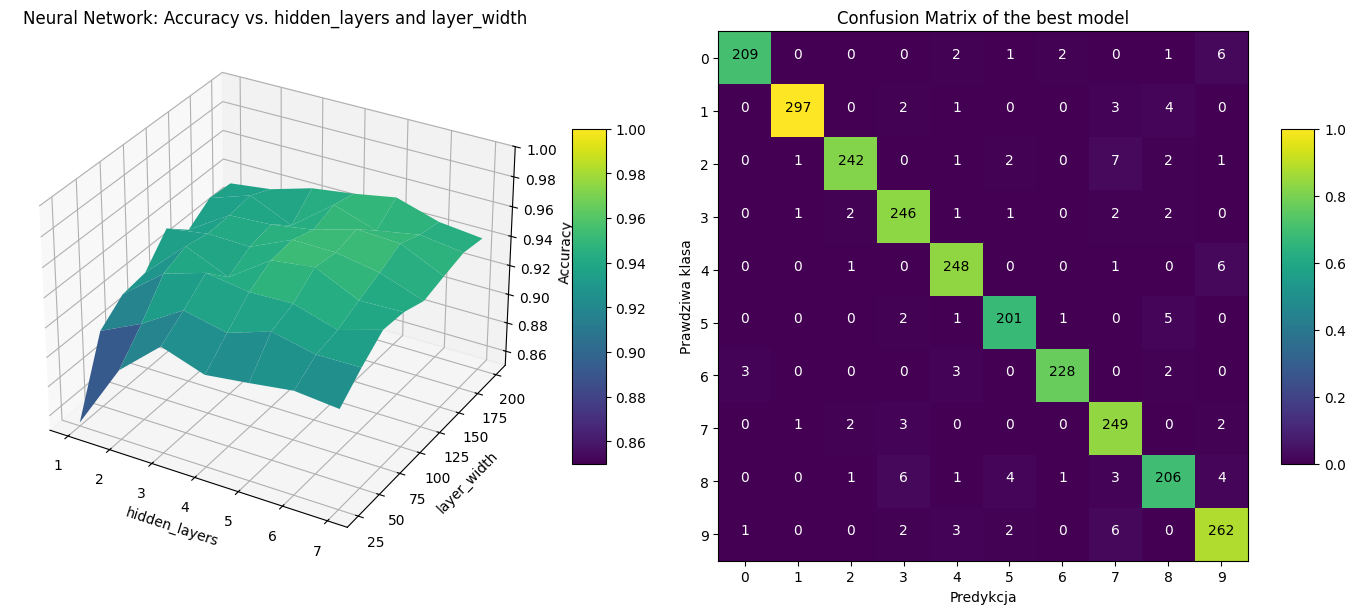

min: 0.8524  max: 0.9552


In [25]:
plot_accuracy_surface(best_NN_model, 'Neural Network', NNresults, 'hidden_layers', 'layer_width')
print("min:", NNresults['accuracy'].min(), " max:", NNresults['accuracy'].max())

Powyższe wizualizacje prezentują podsumowanie badań na zwykłej sieci. Zdecydowawnie najgorzej sieć radziła sobie przy małej liczbie warstw o niewielkich wymiarach. Wygląda to na typowy underfitting, czyli sytuację, gdy model jest zbyt prosty w porównaniu do złożoności problemu. Z drugiej strony bardzo duża liczba wielkich warstw również nie wydaje się optymalnym rozwiązaniem. Na wizualizacji po lewej zauważyć można, że największą dokładność sieć osiągała dla 4-5 warstw o rozmiarze 100-125. <br>
Na przedstawionej, po lewej stronie, macierzy pomyłek pokazane są przewidywania najlepszego modelu podczas jego ewaluacji. Jego skuteczność na poziomie ponad 95% to raczej zadowalający wynik. Warte uwagi są jednak przypadki, gdy jedna liczba była mylona z inną konkretną liczbą w więcej niż 2% przypadków (5 lub więcej razy):
- 0 było mylone z 9 (6 razy)
- 2 była mylona z 7 (7 razy)
- 4 była mylona z 9 (6 razy)
- 5 była mylona z 8 (5 razy)
- 8 była mylona z 3 (6 razy)
- 9 była mylona z 7 (6 razy)

Prawdopodobnie pomyłki te wynikają z charakteru pisma, w zależności od którego mylone liczby mogą w skrajnych przypadkach wyglądać bardzo podobnie zwłaszcza w przypadku liczb 2 i 7, które bez "spodu" w cyfrze "2" byłyby bardzo trudne do odróżnienia.

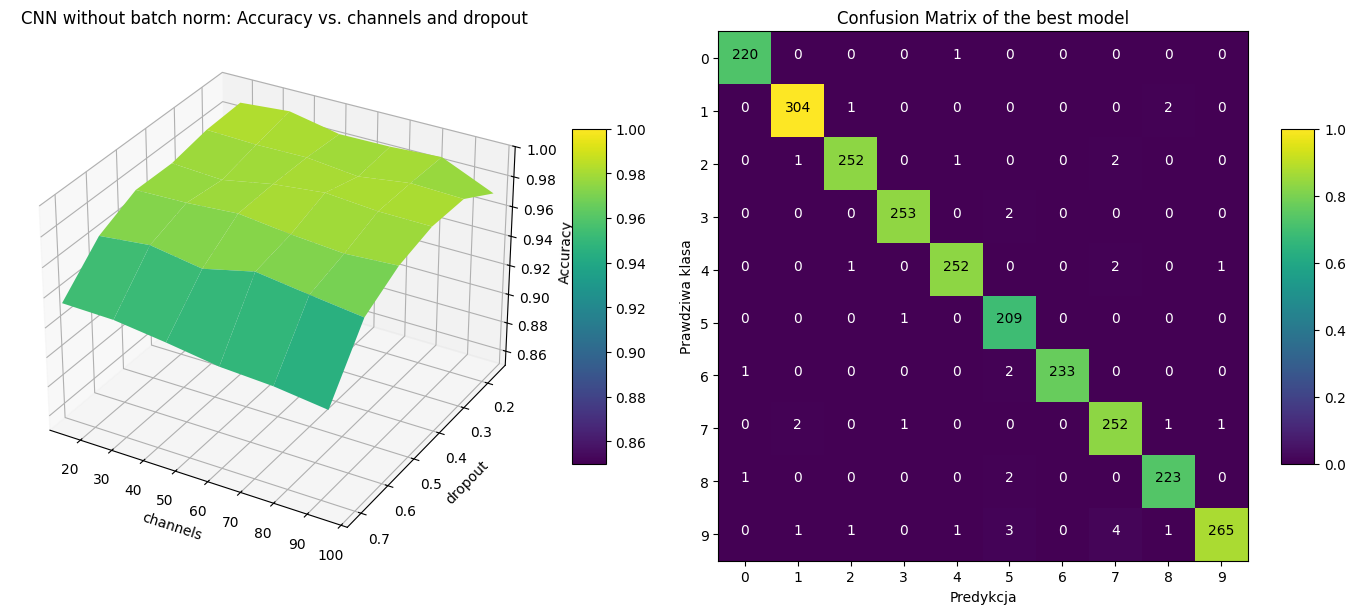

min: 0.9236  max: 0.9852


In [26]:
plot_accuracy_surface(best_CNN_model, 'CNN without batch norm', CNNresults, 'channels', 'dropout', invertYaxis=True)
print("min:", CNNresults['accuracy'].min(), " max:", CNNresults['accuracy'].max())

Następnie mamy wyniki modelu CNN. Model ten radzi sobie lepiej niż zwykła sieć, dzięki większemu naciskowi na lokalne szukanie wzorców, zamiast łączeniu każdego neuronu ze wszystkimi pozostałymi. Wyraźnie widoczny jest wpływ wskaźnika dropout (mającego zwiększać generalizację modelu w celu uniknięcia overfittingu) na dokładność modelu, podczas gdy liczba kanałów zdaje się nie mieć tutaj wpływu. Model radzi sobie bardzo dobrze dla dowolnej kombinacji z dropout `<= 0.5`, przy czym najlepsze wyniki osiągał dla `0.250 <= dropout <= 0.375`. <br>
Na zamieszczonej z boku macierzy pomyłek również widać dość znaczną poprawę w porównaniu ze zwykłą siecią. Model CNN dla około 3000 zdjęć, czyli średnio 300 na każdą cyfrę, przeważnie nie mylił się więcej niż 2 razy. Wyjątek stanowi tutaj tylko cyfra 9, która była mylona z "5" 3 razy oraz z "7" 4 razy.

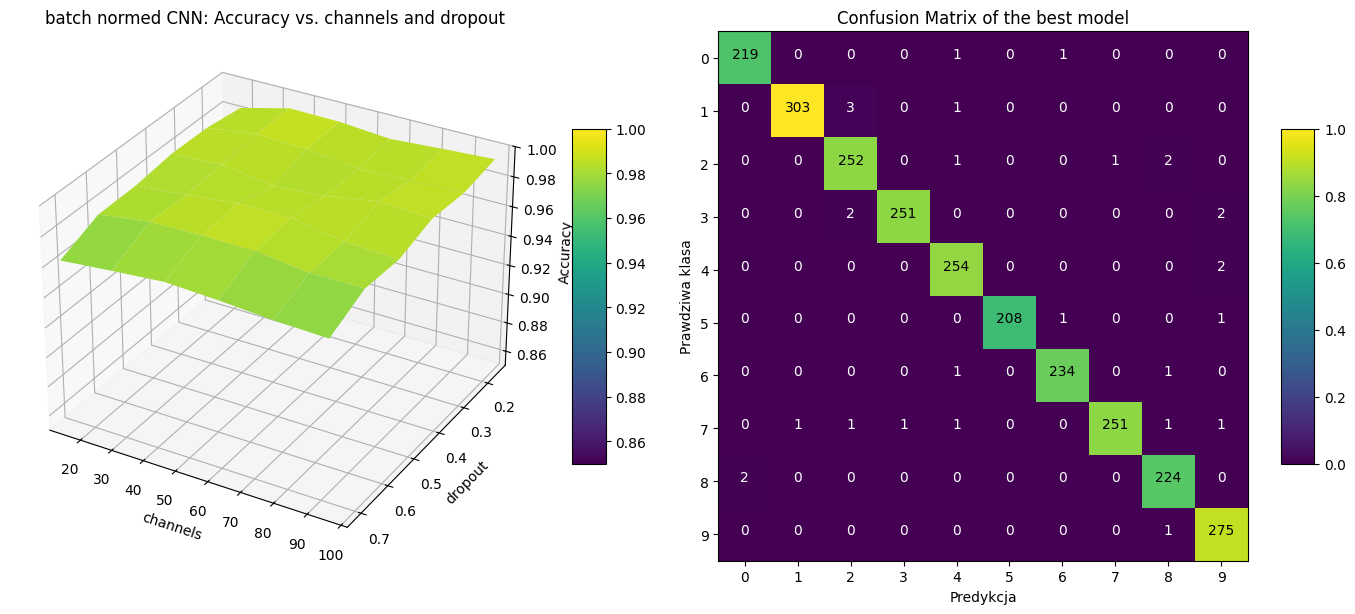

min: 0.9684  max: 0.9884


In [27]:
plot_accuracy_surface(best_batch_normed_CNN_model, 'batch normed CNN', batch_normed_CNNresults, 'channels', 'dropout', invertYaxis=True)
print("min:", batch_normed_CNNresults['accuracy'].min(), " max:", batch_normed_CNNresults['accuracy'].max())

Na końcu pozostał jeszcze CNN z batch norm. Zastosowanie batch norm powinno ułatwić proces uczenia, dzięki standaryzacji różnej dla poszczególnych lokalnych obszarów warstw konwolucyjnych, co zapobiega m.in.: wygaszaniu/wykładniczemu wzrostowi niektórych wag i rzeczywiście ten model osiągnął jeszcze lepsze wyniki niż zwykłe CNN. Poza średnio większą dokładnością modelu, model ten również w większym stopniu zdaje się być odporny na skrajne wartości dropout'u. <br>
Ponadto macierz również wykazuje subtelną poprawę. Tylko w jednym przypadku model pomylił się więcej niż 2 razy - 1 była mylona z "2" 3 razy. <br> <br>
Na zakończenie, porównam jeszcze najlepsze kombinacje wszystkich badanych modeli w dłuższej perspektywie. W powyższych badaniach trening wynosił 5 epok, podczas gdy tu próbuję większą wartość :)

In [30]:
best_batch_normed_CNN = batch_normed_CNNresults[batch_normed_CNNresults['accuracy'] == batch_normed_CNNresults['accuracy'].max()]
Neural_model_CNN_batch_norm = CNN(
    channels_num=best_batch_normed_CNN['channels'].iloc[0],
    dropout_rate=best_batch_normed_CNN['dropout'].iloc[0],
    batch_norm=True
).to(device)
history_CNN_batch_norm = train_model(Neural_model_CNN_batch_norm, epochs=40, track_history=True)

Czas treningu: 246.2s


In [31]:
best_CNN = CNNresults[CNNresults['accuracy'] == CNNresults['accuracy'].max()]
Neural_model_CNN = CNN(
    channels_num=best_CNN['channels'].iloc[0],
    dropout_rate=best_CNN['dropout'].iloc[0]
).to(device)
history_CNN = train_model(Neural_model_CNN, epochs=40, track_history=True)

Czas treningu: 129.1s


In [32]:
best_NN = NNresults[NNresults['accuracy'] == NNresults['accuracy'].max()]
Neural_model_NN = BaselineNN(
    layers_num=best_NN['hidden_layers'].iloc[0],
    layer_width=best_NN['layer_width'].iloc[0]
).to(device)
history_NN = train_model(Neural_model_NN, epochs=40, track_history=True)

Czas treningu: 93.4s


Modele przebadane, więc teraz czas na wizualizację. Na poniższej wizualizacji podzieliłem modele kolorystycznie w następujący sposób:
- zwykła sieć NN na czerwono
- sieć CNN na zielono
- sieć CNN z batch norm na niebiesko

Dodatkowo wykresy danych treningowych kreślone są jaśniejszym odcieniem, podczas gdy dla danych walidacyjnych wykorzystane są ciemniejsze odcienie.

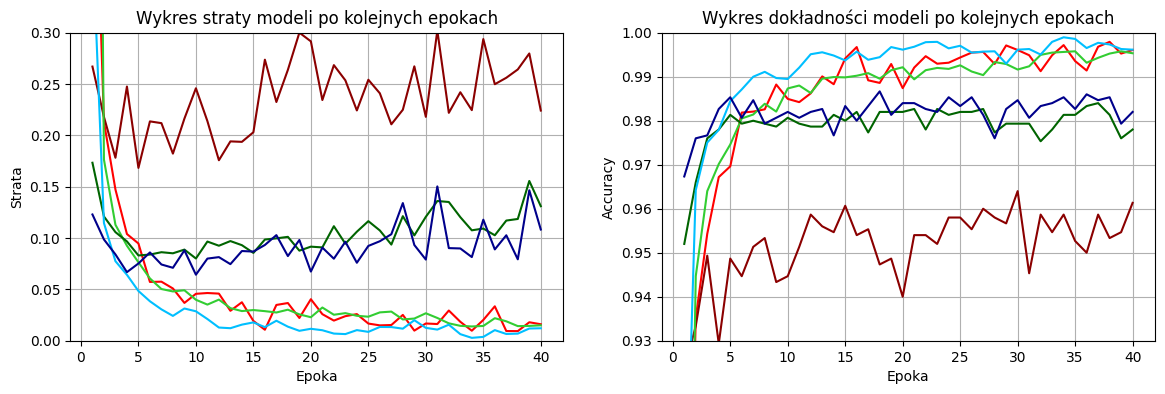

In [68]:
epochs = 40
def plot_history(history, colors):
    plt.subplot(1, 2, 1)
    plt.title("Wykres straty modeli po kolejnych epokach")
    plt.plot(np.arange(1,epochs+1), history["train_loss"], color=colors[0])
    plt.plot(np.arange(1,epochs+1), history["val_loss"], color=colors[1])
    plt.xlabel("Epoka")
    plt.ylabel("Strata")
    plt.ylim(0.0, 0.3)
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title("Wykres dokładności modeli po kolejnych epokach")
    plt.plot(np.arange(1,epochs+1), history["train_acc"], color=colors[0])
    plt.plot(np.arange(1,epochs+1), history["val_acc"], color=colors[1])
    plt.xlabel("Epoka")
    plt.ylabel("Accuracy")
    plt.ylim(0.93, 1.0)
    plt.grid()

plt.figure(figsize=(14,4))
plot_history(history_NN, ['red', 'darkred'])
plot_history(history_CNN, ['limegreen', 'darkgreen'])
plot_history(history_CNN_batch_norm, ['deepskyblue', 'darkblue'])
plt.show()

Na powyższych wizualizacjach zauważyć można, że wszystkie modele porównywalnie dobrze dopasowują się do danych treningowych. Różnica widoczna jest dopiero dla danych walidacyjnych, gdzie sieć NN radzi sobie zdecydowanie gorzej od sieci CNN. Dodatkowo dla sieci NN po 15 epoce występuje powoli rosnący overfitting, objawiający się wzrostem wartości funkcji straty. W przypadku modeli CNN aż do epoki 27 nie widać zjawiska overfittingu. Do tego momentu modele CNN osiągają jednak dokładność powyżej 99%, a w przypadku CNN z batch norm, nawet powyżej 99.5%.

---
Podsumowując, wszystkie badane modele wykazały dobrą skuteczność w identyfikowaniu cyfr ze zbioru danych. Sieć NN wykazuje większą prostotę zarówno w architekturze modelu, jak i w czasie potrzebnym na trening, kosztem jednak nieco mniejszej skuteczności od pozostałych modeli. Zastosowane w modelach CNN mechanizmy uodpornienia modelu, takie jak dropout czy batch norm, wykazały zauważalną poprawę skuteczności modelu, zwłaszcza na danych walidacyjnych jak i testowych